In [ ]:
#| default_exp Learner

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from dlfs.Dataset import *

In [ ]:
#|export
import math,torch,matplotlib.pyplot as plt
from torch import tensor,nn,no_grad
import torch
import torch.nn.functional as F
import fastcore.all as fc
from torch import optim
from copy import copy
from fastprogress import progress_bar,master_bar

import torchvision.transforms.functional as TF


In [ ]:
#| export
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = self.batch
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        # self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [ ]:
from datasets import load_dataset,load_dataset_builder
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Found cached dataset fashion_mnist (/Users/felix/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
bs = 1024
tds = dsd.with_transform(transformi)
    

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=0)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([4, 9, 7, 6, 2, 6, 7, 3, 6, 9]))

In [ ]:
m,nh,out = 28*28,50,10
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,out))

learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(3)


0 True 1.1544134114583333 0.6107833333333333
0 False 1.105757924107143 0.6230571428571429
1 True 0.9187689302884615 0.6803461538461538
1 False 0.9000624441964286 0.6855285714285714
2 True 0.814020703125 0.713905
2 False 0.8054018601190476 0.7165952380952381


## Callbacks

In [ ]:
#| export
def identity(*args):
    if not args: return
    x,*args=args
    return (x,)+tuple(args) if args else x

In [ ]:
#| export 
class Callback: order = 0

In [ ]:
#| export
from torcheval.metrics import MulticlassAccuracy,Mean

class MetricsCB(Callback):
    def __init__(self, *ms, **metrics): 
        for o in ms: metrics[type(o).__name__]=o
        self.metrics=metrics
        self.all_metrics=copy(metrics)
        self.all_metrics['loss']=self.loss = Mean()
        
    def _log(self,d): print(d)
        
    def before_fit(self): self.learner.metrics=self
    def before_epoch(self): [o.reset() for o in self.all_metrics.values()]
    def after_epoch(self): 
        log={k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = self.learner.epoch
        log['train']=self.learner.model.training
        self._log(log)
    def after_batch(self):
        x,y=self.learner.xb, self.learner.yb
        for m in self.metrics.values(): m.update(self.learner.preds, y)
        self.loss.update(self.learner.loss, weight=len(x))

In [ ]:
#| export 
class ProgressCB(Callback):
    order=MetricsCB.order+1
    def __init__(self, plot=False): self.plot=plot
    def before_fit(self):
        self.learner.epochs = self.mbar = master_bar(self.learner.epochs)
        self.first = True
        if hasattr(self.learner,'metrics'): self.learner.metrics._log=self._log
        self.losses=[]
    def _log(self,d): 
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
    def before_epoch(self): self.learner.dl = progress_bar(self.learner.dl, leave=False, parent = self.mbar)
    def after_batch(self):
        self.learner.dl.comment = f'{self.learner.loss: .3f}'
        if self.plot and hasattr(self.learner, 'metrics') and self.learner.model.training:
            self.losses.append(self.learner.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])
        

In [ ]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [ ]:
#| export
class with_callbacks:
    def __init__(self,nm): self.nm=nm
    
    def __call__(self,f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
        return _f

In [ ]:
#| export 
class Core:
    def predict(self): self.learner.preds = self.learner.model(self.learner.xb)
    def get_loss(self): self.learner.loss = self.learner.loss_func(self.learner.preds, self.learner.yb)
    def backward(self): self.learner.loss.backward()
    def step(self): self.learner.opt_func.step()
    def zero_grad(self): self.learner.opt.zero_grad()

In [ ]:
#|export
class MomentumLearner(Core):
    def __init__(self, mom=0.85):
        self.mom = mom
        super().__init__()

    def zero_grad(self):
        with torch.no_grad():
            for p in self.learner.model.parameters(): p.grad *= self.mom

In [ ]:
#| export
class Learner:
    def __init__(self, model, core, dls, callbacks, loss_func, lr, opt_func=optim.SGD): 
        fc.store_attr()
        for cb in self.callbacks: cb.learner=self
        self.callbacks.sort
        self.core.learner=self

    @with_callbacks('batch')
    def one_batch(self):
        self.xb,self.yb = self.batch
        self.core.predict()
        self.core.get_loss()
        if self.model.training:
            self.core.backward()
            self.core.step()
            self.core.zero_grad()

    def one_epoch(self, train):
        self.model.training = train
        self.dl = self.dls.train if train else self.dls.valid
        self._one_epoch()
    
    @with_callbacks('epoch')
    def _one_epoch(self):
        for self.num,self.batch in enumerate(self.dl): self.one_batch()

        
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self._fit()
            
    @with_callbacks('fit')
    def _fit(self):
        for self.epoch in self.epochs:
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

    def callback(self, method_nm): 
        for cb in self.callbacks: getattr(cb, method_nm, identity)()   

In [ ]:
class Trainer:
    def __init__(self, core, model, train, validate, callbacks, loss_fn, opt_fn=optim.SGD, lr=0.5):
        fc.store_attr()
        for cb in self.callbacks: cb.trainer=self
        self.callbacks.sort
        self.core.trainer=self
    
    @with_callbacks('batch')
    def one_batch(self):
        self.core.predict()
        self.core.get_loss()
        if self.model.training:
            self.core.backward()
            self.core.step()
            self.core.zero_grad()
            
    
    def one_epoch(self, train):
        self.model.training=train
        self.dl = self.train if train else self.validate
        self._one_epoch()
        
    @with_callbacks('epoch')
    def _one_epoch(self):
        for self.num,(self.xb, self.yb) in enumerate(self.dl): self.one_batch()    
    

    def fit(self,num_epochs):
        self.accs, self.losses, self.ns = [],[],[]
        self.opt=self.opt_fn(self.model.parameters(), self.lr)
        self.num_epochs=num_epochs
        self.epochs=range(num_epochs)
        self._fit()
            
    @with_callbacks('fit')
    def _fit(self):
        for self.epoch in self.epochs: 
            self.one_epoch(True)
            self.one_epoch(False)

    def callback(self, method_nm): 
        for cb in self.callbacks: getattr(cb, method_nm, identity)()        

In [ ]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self):
        if not self.trainer.model.training: raise CancelEpochException()
        self.lrs.append(self.trainer.opt.param_groups[0]['lr'])
        loss = self.trainer.loss
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in self.trainer.opt.param_groups: g['lr'] *= self.lr_mult

In [ ]:
t,v=Dataset.get_dataset()

In [ ]:
m,nh,out = 28*28,50,10
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,out))
loss_func=nn.CrossEntropyLoss()

accuracy,loss,epoch,train
0.618,1.159,0,True
0.695,0.912,0,False
0.741,0.709,1,True
0.743,0.689,1,False
0.777,0.618,2,True
0.799,0.574,2,False


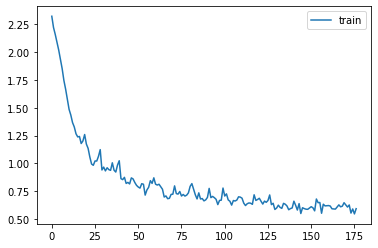

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
train=Learner(model, Core(), dls, [metrics,ProgressCB(plot=True)],F.cross_entropy,lr=0.2)
train.fit(3)

In [ ]:
import nbdev; nbdev.nbdev_export()